# Text Recognition with CTC

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [1]:
import ctc_utils as utils
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(utils)

<module 'ctc_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/text_recognition/ctc_utils.py'>

In [3]:
img_size = (32, 128)
# data = pd.read_pickle('../../pickle/letter_detection_data.pickle')
# df = data['df']
# preprocessed_imgs = data['preprocessed_imgs']

# print("Length: ", len(df))
# print("Imgs length: ", len(preprocessed_imgs))
# print("Img shape: ", preprocessed_imgs[0].shape)

In [4]:
full_df = pd.read_pickle('../../pickle/df.pickle')
print("Length: ", len(full_df))
ctc_df = full_df[['transcription', 'word_img_path', 'word_id']]
ctc_df.head(3)

Length:  96420


,transcription,word_img_path,word_id
0,A,../data/words/a01/a01-000u/a01-000u-00-00.png,a01-000u-00-00
1,MOVE,../data/words/a01/a01-000u/a01-000u-00-01.png,a01-000u-00-01
2,to,../data/words/a01/a01-000u/a01-000u-00-02.png,a01-000u-00-02


In [5]:
reload(utils)
offset=75616
# utils.generate_preprocessed_imgs_from_df(ctc_df, offset=offset)

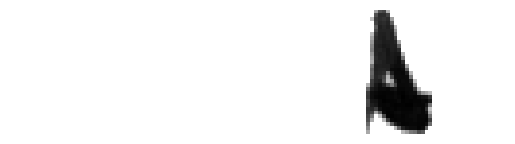

In [9]:
gray_img = cv2.imread('preprocessed_text_imgs/' + ctc_df.iloc[0].word_id + '.png', 0)
plt.imshow(gray_img, cmap='gray');
plt.axis('off');


In [10]:
gray_img.shape

(32, 128)

In [11]:
offset=75616

df = ctc_df.iloc[:offset][['transcription', 'word_id']]
df['img'] = df['word_id'].apply(lambda x: cv2.imread('preprocessed_text_imgs/' + x + '.png', 0))

In [ ]:
# from os.path import exists
# ctc_df_path = '../../pickle/ctc_df.pickle'

# if exists(ctc_df_path):
#     df = pd.read_pickle(ctc_df_path)
# else:
#     ctc_df
#     pickle.dump(ctc_df, open(ctc_df_path, "wb" ))


In [35]:
df.head()

,transcription,word_id,img
0,A,a01-000u-00-00,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,MOVE,a01-000u-00-01,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,to,a01-000u-00-02,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,stop,a01-000u-00-03,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,Mr.,a01-000u-00-04,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [12]:
import string

char_list = list(string.ascii_letters)+[' '] 

def extract_allowed_chars_from_string(char_list, str):
    res = ''
    for letter in str:
        if letter in char_list:
            res += letter
    return res

df['clean_trans'] = df.transcription.apply(lambda x: extract_allowed_chars_from_string(char_list, x))
df.head()

,transcription,word_id,img,clean_trans
0,A,a01-000u-00-00,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",A
1,MOVE,a01-000u-00-01,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",MOVE
2,to,a01-000u-00-02,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",to
3,stop,a01-000u-00-03,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",stop
4,Mr.,a01-000u-00-04,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Mr


In [13]:
print("Taille avant nettoyage:", len(df))
df = df[df['clean_trans'] != ""]
print("Taille après nettoyage:", len(df))

Taille avant nettoyage: 75616
Taille après nettoyage: 66842


## Model Doc

### CNN Part


The idea here is to cut our image into several features (could be interpreted as smaller areas of the picture).

<img src="imgs/cnn_result.png" />

To do so, we ill use a succession of 
- **Convolution** to extract
- **Batch Normalization** to prevent our model from overfitting (equivalent of Dropout) 

#### Batch normalization

TLDR: Solve **internal covariate shift** and simplify 

**Normalization** is a procedure to change the value of the numeric variable in the dataset to a typical scale, without misshaping contrasts in the range of value.

**Batch normalization** is a technique for training very deep neural networks that normalizes the contributions to a layer for every mini-batch.

In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does **the distribution of inputs to subsequent layers**.

> We define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training.

These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers.

Batch normalization is a method intended to mitigate internal covariate shift for neural networks.

<img src="imgs/batch_normalization.jpeg" />

This has the impact of settling the learning process and drastically decreasing the number of training epochs required to train deep neural networks.

Sources: 
- https://machinelearning.wtf/terms/internal-covariate-shift/
- https://towardsdatascience.com/batch-normalisation-in-deep-neural-network-ce65dd9e8dbf#:~:text=Batch%20normalization%20solves%20a%20major,you%20can%20often%20remove%20dropout.
- https://towardsdatascience.com/understanding-dataset-shift-f2a5a262a766

#### Conv

<img src="imgs/conv_padding.gif" />

- Padding '**valid**' is the first figure. The filter window stays inside the image. When padding == "VALID", there can be a loss of information. Generally, elements on the right and the bottom of the image tend to be ignored. How many elements are ignored depends on the size of the kernel and the stride.

- Padding '**same**' is the third figure. The output is the same size.


#### Pooling/Flattening

**Pooling** is the process of merging. So it’s basically for the purpose of **reducing the size of the data**.

<img src="imgs/pooling_flattening.png" />

**Flattening** is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector.

Sources: 

- https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480

## Model build

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout


hidden_layer_count = 256

def build_sequential_model():
    model = tf.keras.Sequential()
    # Layer 1
    # (None, 32, 128, 64)
    model.add(Conv2D(
            filters=32,
            kernel_size=(5,5),
            padding='SAME',
            input_shape = (img_size[0], img_size[1], 1)
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 2
    # (None, 16, 64, 64)
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 3
    # (None, 8, 32, 128 -> nb conv filters)
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))


    # Layer 4
    # (None, 4, 32, 128)
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 5
    # (None, 2, 32, 128)
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
    # (None, 1, 32, 256)
    return model
    
# model = build_sequential_model()
# model.summary()

At this point, we have cut our entry image into X smaller parts. Those parts can be read as a time serie.

Indeed, there is a strong connection between one part and the one coming after by construction (a word is a succession of letters).

We can therefore make use of a **RNN** now in our model.

NB: a part does not correspond exactly to a letter, it is more the idea behind it. It could be interesting to see the importance of the size of each part (number of cuts).


### RNN part

In [21]:
print(tf.__version__)

2.9.1


In [15]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda

model = build_sequential_model()
model.add(Lambda(lambda x: tf.squeeze(x, axis=1)))
# (None, 32, 256)
# Bidirectionnal RNN
model.add(Bidirectional(GRU(hidden_layer_count, return_sequences=True)))
model.add(Dense(100))
model.summary()

2022-10-19 22:27:58.899574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

```
NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_gru_3/strided_slice:0) to a numpy array.
```



TODO LSTM could be a good idea ? 

https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c
https://distill.pub/2017/ctc/

## Connectionist Temporal Classification

In [16]:
from sklearn.model_selection import train_test_split

resized_imgs = np.array(df.img.values.tolist())
resized_imgs = resized_imgs.reshape(-1, img_size[0], img_size[1])
print(resized_imgs.shape)
print(resized_imgs[0].shape)
X_train, X_test, y_train, y_test = train_test_split(resized_imgs, df.clean_trans.values, test_size=0.1)

(66842, 32, 128)
(32, 128)


### Encoder/Decoder

In [17]:
def encode_labels(labels, char_list):
    # Hash Table
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            char_list,
            np.arange(len(char_list)),
            value_dtype=tf.int32
        ),
        -1,
        name='char2id'
    )
    return table.lookup(
    tf.compat.v1.string_split(labels, delimiter=''))

def decode_codes(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

transcrip_test = y_train[:5]
encoded_labels = encode_labels(transcrip_test, char_list)
decoded_codes = decode_codes(encoded_labels, char_list)
# print('transcrip_test', transcrip_test)
# print('encoded_labels', encoded_labels)
# print('-----------------')
# print('decoded_codes', decoded_codes)

tf.sparse.to_dense(decoded_codes)

<tf.Tensor: shape=(5, 8), dtype=string, numpy=
array([[b'f', b'i', b'r', b'm', b's', b'', b'', b''],
       [b'h', b'i', b's', b'', b'', b'', b'', b''],
       [b'w', b'e', b'', b'', b'', b'', b'', b''],
       [b'a', b'', b'', b'', b'', b'', b'', b''],
       [b'r', b'e', b'p', b'e', b'a', b't', b'e', b'd']], dtype=object)>

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train,-1), y_train))
dataset = dataset.shuffle(1000).batch(64)

In [19]:
def loss(labels, logits):
    return tf.reduce_mean(
            tf.nn.ctc_loss(
                labels = labels,
                logits = logits,
                logit_length = [logits.shape[1]]*logits.shape[0],
                label_length = None,
                logits_time_major = False,
                blank_index=-1
            )
        )

        
def train_op(model, optimizer, inputs, targets):
    with tf.GradientTape() as tape:
        # Prédiction de notre modèle
        y_pred = model(inputs, training=True)
        # Calcule de l'erreur de notre modèle
        loss_value = tf.reduce_mean(loss(targets, y_pred))
       
    # Calculer le gradient de la fonction de perte
    grads = tape.gradient(loss_value, model.trainable_variables)
    # Descente de gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # Retourner la valeur de la fonction de perte
    return loss_value.numpy()



In [20]:
import sys
import time

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs = 5

# Entraînement du modèle
for i in range(epochs): 
    # Pour chaque epoch
    print('---- Epoch', i, '----')
    j = 0
    for X_b, y_b in dataset:

        try :
            y_ba = encode_labels(y_b, char_list)
            print("Batch {}".format(j), train_op(model, optimizer, X_b, y_ba))
        except :
            print("Unexpected error:", sys.exc_info()[0])
            time.sleep(0.5)
        j += 1

---- Epoch 0 ----
Batch 0 134.1951
Batch 1 129.79001
Batch 2 117.8137
Batch 3 109.54178
Batch 4 100.217865
Batch 5 91.86391
Batch 6 81.02756
Batch 7 70.63486
Batch 8 66.0002
Batch 9 58.58634
Batch 10 54.318512
Batch 11 51.92154
Batch 12 43.806015
Batch 13 44.142117
Batch 14 43.405
Batch 15 40.191875
Batch 16 36.186165
Batch 17 34.285538
Batch 18 31.908035
Batch 19 29.43759
Batch 20 27.253178
Batch 21 26.02683
Batch 22 27.611076
Batch 23 23.643742
Batch 24 19.641586
Batch 25 21.93119
Batch 26 23.717598
Batch 27 24.147411
Batch 28 22.648987
Batch 29 24.632994
Batch 30 25.38755
Batch 31 18.559849
Batch 32 22.323597
Batch 33 21.148144
Batch 34 21.085743
Batch 35 24.488308
Batch 36 18.70787
Batch 37 18.346981
Batch 38 21.56184
Batch 39 20.016846
Batch 40 19.127436
Batch 41 18.528725
Batch 42 19.794342
Batch 43 17.231451
Batch 44 17.924992
Batch 45 17.72089
Batch 46 20.356714
Batch 47 18.952034
Batch 48 19.538958
Batch 49 21.648264
Batch 50 17.735643
Batch 51 16.466806
Batch 52 16.7773
Batch

In [21]:
def greedy_decoder(logits):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )
    
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    
    # Decode the index of caracter
    text = decode_codes(codes, char_list)
    
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    
    return list(map(lambda x: ''.join(x), text))

predicted_transcriptions = greedy_decoder(model(np.expand_dims(X_test[:10], -1)))
list(zip(predicted_transcriptions, y_test[:10]))

[('eehosloosl', 'Czechoslovak'),
 ('paurty', 'party'),
 ('snertieng', 'smoothing'),
 ('bese', 'more'),
 ('rouigttiactins', 'neighbourliness'),
 ('ee', 'no'),
 ('this', 'this'),
 ('canmot', 'cannot'),
 ('castes', 'centres'),
 ('enothing', 'nothing')]